In [39]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

In [46]:
tennis <- read_csv('player_stats.csv')
colnames(tennis) <- make.names(colnames(tennis))

tennis_data <- tennis |>
filter(Active == "Yes") |>
select(Age:Plays, Current.Rank:Prize.Money, Seasons, Current.Elo.Rank:Peak.Elo.Rating) |>
separate(col = Age, into = c("Age", "Birth.Date"), sep = " ") |>
separate(col = Current.Rank, into = c("Current.Rank", "Prev.Rank"), sep = " ") |>
separate(col = Best.Rank, into = c("Best.Rank", "Best.Rank.Date"), sep = " ") |>
separate(col = Current.Elo.Rank, into = c("Current.Elo.Rank", "Current.Elo.Rating"), sep = " ") |>
separate(col = Best.Elo.Rank, into = c("Best.Elo.Rank", "Best.Elo.Rank.Date"), sep = " ") |>
separate(col = Peak.Elo.Rating, into = c("Peak.Elo.Rating", "Peak.Elo.Rating.Date"), sep = " ") |>
mutate(Current.Rank = as.numeric(Current.Rank), Current.Elo.Rank = as.numeric(Current.Elo.Rank), Age = as.numeric(Age),
       Best.Elo.Rank = as.numeric(Best.Elo.Rank), Peak.Elo.Rating = as.numeric(Peak.Elo.Rating), Best.Rank = as.numeric(Best.Rank),
       Prize.Money = as.numeric(gsub("[^0-9.-]", "", Prize.Money)),
       Current.Elo.Rating = as.numeric(gsub("[^0-9.-]", "", Current.Elo.Rating)),
       Prev.Rank = as.numeric(gsub("[^0-9.-]", "", Prev.Rank)),
       Money.Per.Season = Prize.Money/Seasons) |>
select(Name, Age, Seasons, Current.Rank, Prev.Rank, Best.Rank, Current.Elo.Rank, Current.Elo.Rating, Best.Elo.Rank, Peak.Elo.Rating,
           Prize.Money, Money.Per.Season)|>
select(Name, Age, Current.Rank, Current.Elo.Rating, Money.Per.Season)|>
drop_na()

tennis_data

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Name,Age,Current.Rank,Current.Elo.Rating,Money.Per.Season
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Lukas Lacko,32,178,1764,232969.1
Bernard Tomic,27,183,1826,553815.5
Hubert Hurkacz,22,31,1983,303431.4
⋮,⋮,⋮,⋮,⋮
Brayden Schnur,24,103,1627,103659.25
Mirza Basic,28,292,1764,149759.14
Dimitar Kuzmanov,26,324,1679,16608.88


In [47]:
set.seed(16)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = Money.Per.Season)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

[1] 3

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,403879.2,5,159178.2,Preprocessor1_Model01
2,rmse,standard,367663.3,5,173068.5,Preprocessor1_Model02
3,rmse,standard,361657.0,5,179659.7,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,rmse,standard,395651.7,5,191509.3,Preprocessor1_Model28
29,rmse,standard,397207.1,5,191891.2,Preprocessor1_Model29
30,rmse,standard,397283.6,5,192630.3,Preprocessor1_Model30


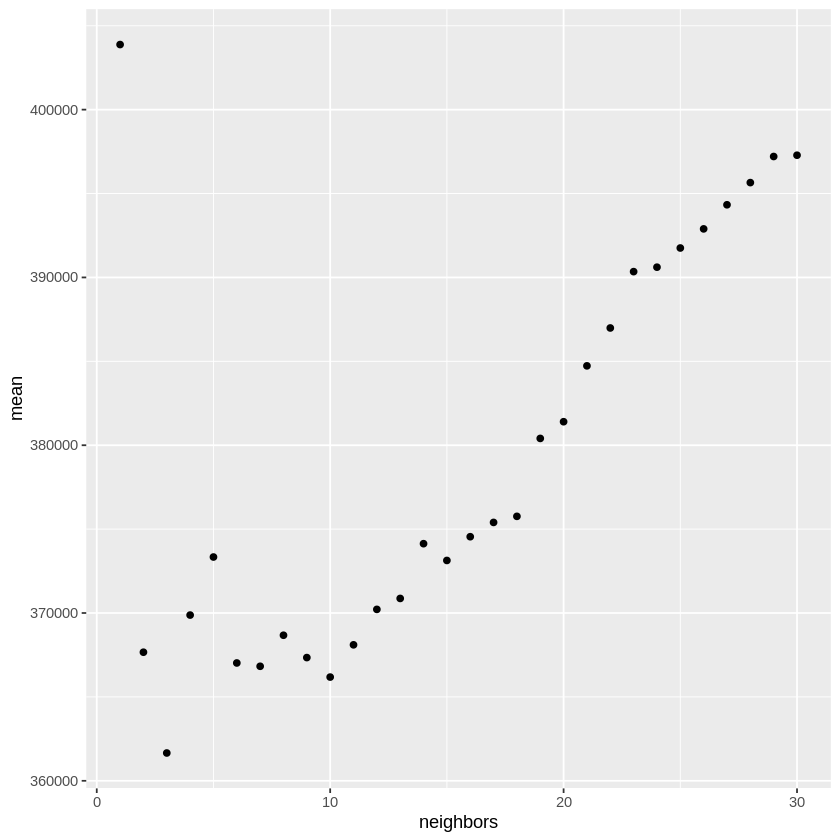

In [48]:
tennis_recipe <- recipe(Money.Per.Season~Age + Current.Rank + Current.Elo.Rating, data = tennis_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

tennis_vfold <- vfold_cv(tennis_training, v = 5, strata = Money.Per.Season)

tennis_wkflw <- workflow() |>
add_recipe(tennis_recipe) |>
add_model(tennis_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 30))
tune_results <- tennis_wkflw |>
tune_grid(resamples = tennis_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "rmse")

best_k <- filter(tune_results, mean == min(mean)) |>
pull(neighbors)
best_k 
tune_results

neighbors_plot <- tune_results |>
ggplot(aes(x = neighbors, y = mean)) +
geom_point()

neighbors_plot

In [51]:
best_tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
set_engine("kknn") |>
set_mode("regression")

tennis_fit <- workflow() |>
add_recipe(tennis_recipe) |>
add_model(best_tennis_spec) |>
fit(data = tennis_training)

tennis_summary <- tennis_fit |>
predict(tennis_testing) |>
bind_cols(tennis_testing) |>
metrics(truth = Money.Per.Season, estimate = .pred) |>
filter(.metric == "rmse")
tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,347601.4
